In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.impute import SimpleImputer, KNNImputer
from category_encoders import TargetEncoder
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.linear_model import Lasso, Ridge, RidgeCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
import gensim
import warnings
import spacy
from pandas.core.common import SettingWithCopyWarning

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Task 2 - Word Vectors

In [3]:
# Read data and drop all non-US wines
wine_data_130 = pd.read_csv('wine-reviews/winemag-data-130k-v2.csv', index_col=0)
wine_data_130 = wine_data_130[wine_data_130['country'] == 'US'] 

In [4]:
#drop everything below a 95% condidence interval 
def remove_minor_outlier(df, columns):
    low = 0
    high = .95
    quant_df = df.quantile([low, high])
    for name in list(columns):
        df = df[(df[name] > quant_df.loc[low, name]) & (df[name] < quant_df.loc[high, name])]
    return df

In [5]:
def remove_cat_outlier(df, column):
    num_low_values = len([x for x in df[str(column)].dropna().value_counts() if x < 5])
    low_value_list = list(pd.Series(df[str(column)].dropna().value_counts()[-num_low_values:]).index)
    output = df[~df[column].isin(low_value_list)]
    return output

## Remove Outliers + Sample Data
- Remove outliers, sample data, drop country column and seperate 'points' from training data

In [6]:
wine_data_130 = wine_data_130[wine_data_130['points'] <=98]
wine_data_130 = remove_minor_outlier(wine_data_130,['price']) #removing the outliers

In [7]:
#dropping categories that have less than 5 entries 
wine_data_130 = remove_cat_outlier(wine_data_130,'region_1')
wine_data_130 = remove_cat_outlier(wine_data_130,'province')
wine_data_130 = remove_cat_outlier(wine_data_130,'variety')
wine_data_130 = remove_cat_outlier(wine_data_130,'winery')
wine_data_130 = remove_cat_outlier(wine_data_130,'designation')

In [8]:
wine_data_130 = wine_data_130.drop(columns=['taster_twitter_handle'])

In [9]:
# Remove outliers and sample data, taking half of the dataset
wine_data_130 = wine_data_130.sample(frac=0.5)

In [10]:
points = wine_data_130['points']
X = wine_data_130.drop(columns=['country', 'points'])
X.head()

,description,designation,price,province,region_1,region_2,taster_name,title,variety,winery
97244,"Seductive aromas of caramel, fresh-crushed sod...",Sanford & Benedict Vineyard,36.0,California,Sta. Rita Hills,Central Coast,Matt Kettmann,Sanford 2012 Sanford & Benedict Vineyard Viogn...,Viognier,Sanford
10742,A blend of 60% Syrah from Ambassador Vineyard ...,NaN,29.0,Washington,Red Mountain,Columbia Valley,Sean P. Sullivan,Corvus 2010 Syrah-Petite Sirah (Red Mountain),Syrah-Petite Sirah,Corvus
74763,There are only a few examples of Grüner Veltli...,NaN,24.0,Washington,Washington,Washington Other,Sean P. Sullivan,Syncline 2016 Grüner Veltliner (Washington),Grüner Veltliner,Syncline
128054,"White flowers, nectarine, red apple and a stee...",NaN,33.0,California,Santa Barbara County,Central Coast,Matt Kettmann,Sandhi 2013 Chardonnay (Santa Barbara County),Chardonnay,Sandhi
83677,"Shows some Riesling character in the petrol, h...",Dry,18.0,California,Central Coast,Central Coast,NaN,Claiborne & Churchill 2007 Dry Riesling (Centr...,Riesling,Claiborne & Churchill


## Impute Missing Values

In [11]:
categorical = ['designation', 'province', 'region_1', 'region_2', 'variety', 'winery', 'taster_name']
continuous = ['price']
impute_categorical = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
impute_float = KNNImputer(missing_values=np.nan)

In [12]:
X[categorical] = impute_categorical.fit_transform(X[categorical])
X[continuous] = impute_float.fit_transform(X[continuous])

## Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, points, shuffle=True, random_state=0)
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=0)

### Use a pretrained word-embedding for featurization instead of BoW

- Word2Vec: a shallow neural network which takes a large set of words and produces a vector space (vectorizes the words)
- Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space
- Use pretrained Google Model which has 300 features (300 dimensions) trained on 3 million words
- Includes some stop words while others are not included


### Load a pretrained Google News Model

In [14]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
print(f'Number of words in model vocab: {len(model.vocab.keys())}')

Number of words in model vocab: 3000000


### Create a Spacy an empty nlp object and load the pretrained model into the object

In [15]:
# Create a blank english object
nlp = spacy.blank('en')
keys = []
for idx in range(len(model.vocab.keys())):
    keys.append(model.index2word[idx])

# Set the vectors for our nlp object to the google news vectors
nlp.vocab.vectors = spacy.vocab.Vectors(data=model.vectors, keys=keys)
print(f'The dimensions of pretrained model: {nlp.vocab.vectors.shape}')

The dimensions of pretrained model: (3000000, 300)


### Use the model to featurize the 'description' and 'title' text features
- Will create a 300 dimension word vector for each word in the 'description'
- Final output is an average of all the word vectors in the paragraph

In [16]:
desc_vec = [nlp(x).vector for x in X_train['description']]
title_vec = [nlp(x).vector for x in X_train['title']]

In [17]:
title_coded = np.vstack(title_vec)
description_coded = np.vstack(desc_vec)

In [18]:
total_coded = np.concatenate((description_coded, title_coded), axis=1)

### Train linear models only using the 'description' and 'title' text features

In [19]:
param_grid = {'alpha': np.logspace(-3,3,15)}
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(total_coded, y_train)
ridge_grid.best_score_

0.5727407081940231

In [20]:
param_grid = {'alpha': np.logspace(-3,3,15)}
lasso_grid = GridSearchCV(Lasso(), param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(total_coded, y_train)
lasso_grid.best_score_

0.5315037859077342

### Use a combination of text and non-text features

In [19]:
# Encode categorical features 
to_target_encode = ['designation', 'winery', 'variety', 'region_1', 'region_2']
to_ohe = ['province', 'taster_name']
to_scale = ['price']
# Create column transformer
ohe = make_pipeline(preprocessing.OneHotEncoder(handle_unknown='ignore'))
scale = make_pipeline(preprocessing.StandardScaler())
te = make_pipeline(TargetEncoder(), preprocessing.StandardScaler())
preprocessing_pipe = make_column_transformer((ohe, to_ohe),
                                             (te, to_target_encode),
                                             (scale, to_scale),
                                             remainder='passthrough')

In [20]:
X_train_no_text = X_train.drop(columns=['title', 'description'])
X_train_no_text_processed = pd.DataFrame(preprocessing_pipe.fit_transform(X_train_no_text, y_train).toarray())

In [21]:
X_train_encoded = np.concatenate((description_coded, title_coded, X_train_no_text_processed), axis=1)

In [24]:
param_grid = {'alpha': np.logspace(-3,3,15)}
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train_encoded, y_train)
ridge_grid.best_score_

0.7052085357539686

In [25]:
param_grid = {'alpha': np.logspace(-3,3,15)}
lasso_grid = GridSearchCV(Lasso(), param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_train_encoded, y_train)
lasso_grid.best_score_

0.685589829381158

### Does this improve classification?

Compared to task 1, this did not imporove the regression performance. this is almost exactly the same as with the sklearn BOW model. 

### Combining Embedded Words with a BoW model

- Think for this all we have to do is use BoW for one feature and then word2vec for the other text feature?

In [22]:
#encode the text features for BoW 
#Ridge is the top performing model from task 1, so we will use it here as a representation of BoW
ridge_description_tfid_vect = TfidfVectorizer(
                             max_features = 2500,
                             min_df = 4,
                             token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english')

ridge_title_tfid_vect = TfidfVectorizer(
                             max_features = 5000,
                             min_df = 1,
                             token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english')

ridge_text_column_transformer = make_column_transformer(
                                     (ridge_description_tfid_vect, 'description'), 
                                     (ridge_title_tfid_vect, 'title'),
                                     remainder='drop')

In [34]:
## In case you wanted to try Lasso 

lasso_tfid_vect = CountVectorizer(token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english')

lasso_text_column_transformer = make_column_transformer((lasso_tfid_vect, 'description'), 
                                     (lasso_tfid_vect, 'title'),
                                     remainder='drop')

In [23]:
X_train_bow_text = X_train[['description','title']]
x_train_bow = pd.DataFrame(ridge_text_column_transformer.fit_transform(X_train_bow_text).toarray())
X_train_encoded_bow = np.concatenate((X_train_encoded, x_train_bow), axis=1)

### Evaluate Ridge

In [32]:
#cross_validate to determine performance  
ridge_metrics = cross_validate(Ridge(alpha=2.154434690031882),
                               X_train_encoded_bow, y_train, cv =cv_strategy, return_train_score=True)
np.mean(ridge_metrics['train_score'])

0.855179687215055

### Evaluate Lasso

In [35]:
x_train_bow_lasso = pd.DataFrame(lasso_text_column_transformer.fit_transform(X_train_bow_text).toarray())
X_train_encoded_bow_lasso = np.concatenate((X_train_encoded, x_train_bow_lasso), axis=1)

In [36]:
lasso_metrics = cross_validate(Lasso(alpha=0.001),X_train_encoded_bow_lasso, y_train, cv =cv_strategy, return_train_score=True)
np.mean(lasso_metrics['train_score'])

0.8160033694567923

### Graph Cross-Validation Results

In [37]:
def graph_cv_results(lasso_metrics,ridge_metrics):

    cvs_fig, ax = plt.subplots(1, 2, figsize=(15,5),sharex=True, sharey=True)
    ax1, ax3, = ax.ravel()

    ax1.plot(lasso_metrics['train_score'], color='blue')
    ax1.plot(lasso_metrics['test_score'], color='orange')
    ax1.set_title(f'Lasso BoW+Word2Vec performance', fontsize=20)
    ax1.set_xlabel('fold', fontsize=15)
    ax1.set_ylabel('score out of 1.0', fontsize=15)
    ax1.legend(['train_score','test_score'])
    ax3.plot(ridge_metrics['train_score'], color='blue')
    ax3.plot(ridge_metrics['test_score'], color='orange')
    ax3.set_title(f'Ridge BoW+Word2Vec performance', fontsize=20)
    ax3.set_xlabel('fold', fontsize=15)
    ax3.set_ylabel('score out of 1.0', fontsize=15)
    ax3.legend(['train_score','test_score'])
    cvs_fig.tight_layout()

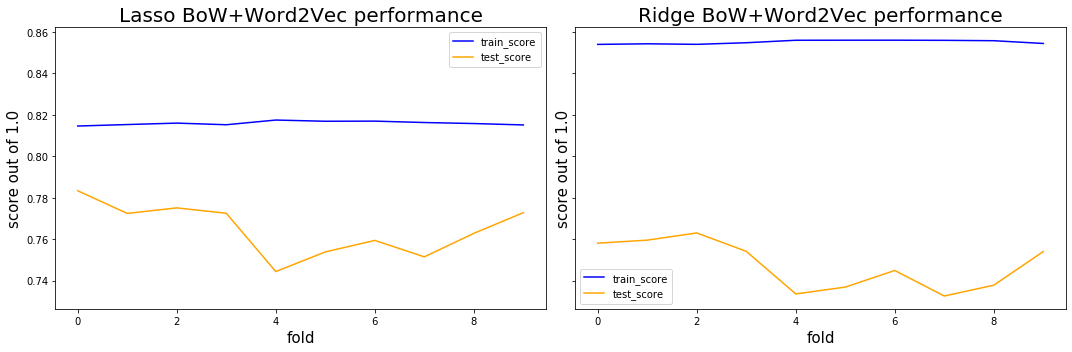

In [38]:
graph_cv_results(lasso_metrics, ridge_metrics)

### Of the above embeddings, use the best combination on the test set

In [40]:
desc_vec_test = [nlp(x).vector for x in X_test['description']]
title_vec_test = [nlp(x).vector for x in X_test['title']]
title_coded_test = np.vstack(title_vec_test)
description_coded_test = np.vstack(desc_vec_test)
total_coded_test = np.concatenate((title_coded_test, description_coded_test), axis=1)

In [50]:
X_test_no_text = X_test.drop(columns=['description', 'title'])
X_test_no_text_processed = pd.DataFrame(preprocessing_pipe.transform(X_test_no_text).toarray())
X_test_bow_text = X_test[['description','title']]
x_test_bow = pd.DataFrame(ridge_text_column_transformer.transform(X_test_bow_text).toarray())

In [51]:
X_test_encoded_bow = np.concatenate((total_coded_test, X_test_no_text_processed, x_test_bow), axis=1)

In [59]:
ridge = Ridge(alpha=2.154434690031882)
ridge.fit(X_train_encoded_bow, y_train)
ridge.score(X_test_encoded_bow, y_test)

0.4693495736921256

# Conclusion:

Based on the models above, the model using a combination of BoW and word2vec encoding while including the non-text features produced the highest cross-validation scores. The model did better than using just word2vec as well as when word2vec was only used. However, the performance on the test set was poor. This is likely because these encodedings each creat very large sparse matrices which can lead to very large number of parameters in linear models, that may overfit.